In [2]:
import pandas as pd
import numpy as np
import numerapi
import sklearn.linear_model
import matplotlib.pylab as plt

from datetime import timedelta
import tqdm

In [94]:
df = pd.DataFrame(data={'Animal': ['cat', 'penguin', 'dog',
                                   'spider', 'snake'],
                        'Number_legs': [4, 2, 4, 8, np.nan]})
df['pct_rank'] = df['Number_legs'].rank(pct=True)
df['pct_rank_1'] = df['Number_legs'].rank(pct=True, method = "first")

In [3]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [4]:
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
training_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.75
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.00
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.00
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [8]:
# download the latest tournament dataset (takes around 30s)
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
tournament_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.00
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.25
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.75
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,1.00


In [9]:
# find only the feature columns
feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]

In [10]:
# select those columns out of the training dataset
training_features = training_data[feature_cols]

In [11]:
target = training_data['target_kazutsugi']

In [12]:
eras = training_data['era']
eras_live = tournament_data.era

In [84]:
N_ERAS_IN_FOLD = 12
N_FOLDS = int(len(eras.unique()) / N_ERAS_IN_FOLD)

eras2_binned = []
current_era = 1
thresh_era_limit = N_ERAS_IN_FOLD
for era in eras:
    era_num = int(era.split('era')[-1])
    if era_num <= thresh_era_limit:
        eras2_binned.append(current_era)
    else:
        current_era += 1
        thresh_era_limit += N_ERAS_IN_FOLD
        eras2_binned.append(current_era)

In [14]:
validation_ids = tournament_data.data_type=='validation'

### Feature importance

In [15]:
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import log_loss, accuracy_score
from sklearn import model_selection

from scipy.cluster.hierarchy import linkage, fcluster
from itertools import product

In [16]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [63]:
REFERENCES = [0.0, 0.25, 0.5, 0.75, 1.0]

In [101]:
def get_base_model(cw = {0: 1,
                          1: 1.1,
                          2: 1,
                          3: 1.1,
                          4: 1
                        }):
    return RidgeClassifier(alpha = 1, 
                           class_weight = cw
                                    )
    
def ridge_classifier_2single_prediction(model, X, temperature = 1.0):
    try:
        predictions_proba_mean = model.decision_function(X)
    except:
        predictions_proba_mean = model.predict_proba(X)
    predictions = np.argmax(predictions_proba_mean, axis=1)
    predictions_proba = np.array([np.exp(di / temperature) / np.sum(np.exp(di / temperature)) for di in predictions_proba_mean])
    single_score_predictions = np.array(
            [
                sum(REFERENCES[i] * x[i] for i in range(len(REFERENCES))) for x in predictions_proba
            ]
        )

    return single_score_predictions

def train_model(X_train, Y_train, model = None):
    if model == None:
        model_i = get_base_model()
    else:
        model_i = model
    model_i.fit(X_train, Y_train)
    return model_i

def calculate_score(train_data, predictions, eras):

    ns = numerai_score(train_data, pd.Series(predictions))
    cs = correlation_score(train_data, pd.Series(predictions))

    df2 = pd.DataFrame(
        {
            "era": eras,
            "preds": predictions,
            "target": train_data
        }
    )

    scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d["target"])[0,1])

    per_era_score, per_era_std = scores_per_era.mean(), scores_per_era.std()
    sharpe_era_score = scores_per_era.mean() / scores_per_era.std()
    return ns, cs, per_era_score, per_era_std, sharpe_era_score


def ridge2probas(model, X, temperature = 1.0):
    try:
        predictions_proba_mean = model.decision_function(X)
    except:
        predictions_proba_mean = model.predict_proba(X)
    predictions = np.argmax(predictions_proba_mean, axis=1)
    predictions_proba = np.array([np.exp(di / temperature) / np.sum(np.exp(di / temperature)) for di in predictions_proba_mean])
    return predictions_proba

def softmax2singlescore(predictions_proba):
    single_score_predictions = np.array(
            [
                sum(REFERENCES[i] * x[i] for i in range(len(REFERENCES))) for x in predictions_proba
            ]
        )

    return single_score_predictions

# Baseline

In [102]:
validation_ids = tournament_data.data_type=='validation'
tournament_data = tournament_data[validation_ids]

In [103]:
le = LabelEncoder()

X = training_features
Y = le.fit_transform(target)
Y_nmr = target

In [104]:
X_test = tournament_data[feature_cols]
Y_test = le.fit_transform(tournament_data.target_kazutsugi)
Y_nmr_test = tournament_data.target_kazutsugi
test_eras = tournament_data.era

In [105]:
clf = get_base_model()
clf.fit(X, Y)
pred_c = clf.predict(X_test)
pred = ridge_classifier_2single_prediction(clf, X_test)

In [106]:
pred

array([0.48991926, 0.49701203, 0.5254302 , ..., 0.50028304, 0.50632513,
       0.49827684])

In [107]:
print(classification_report(pred_c, Y_test))

              precision    recall  f1-score   support

           0       0.28      0.27      0.28     22466
           1       0.22      0.23      0.22     20430
           2       0.25      0.29      0.27     18562
           3       0.21      0.22      0.22     20410
           4       0.32      0.27      0.29     25027

    accuracy                           0.26    106895
   macro avg       0.26      0.26      0.26    106895
weighted avg       0.26      0.26      0.26    106895



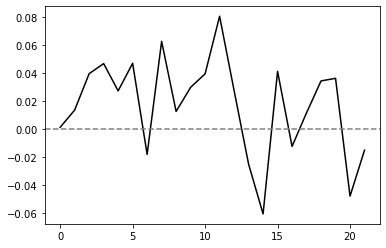

corr_spearman    = 0.016
corr_pearson     = 0.016
per_era_avg_corr = 0.017
per_era_std_corr = 0.035
sharpe_era_corr  = 0.483


In [120]:
ns_bs = numerai_score(Y_nmr_test, pd.Series(pred))
cs_bs = correlation_score(Y_nmr_test, pd.Series(pred))

df2 = pd.DataFrame(
    {
        "era": test_eras,
        "preds": pred,
        "target": Y_nmr_test
    }
)

scores_per_era_bs = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d["target"])[0,1])

per_era_score, per_era_std = scores_per_era_bs.mean(), scores_per_era_bs.std()
sharpe_era_score = scores_per_era_bs.mean() / scores_per_era_bs.std()

plt.figure()
plt.plot(scores_per_era_bs.values, color = 'black')
plt.axhline(0.0, ls = '--', color = 'grey')
plt.show()
print('corr_spearman    = {}'.format(round(ns_bs, 3)))
print('corr_pearson     = {}'.format(round(cs_bs, 3)))
print('per_era_avg_corr = {}'.format(round(per_era_score, 3)))
print('per_era_std_corr = {}'.format(round(per_era_std, 3)))
print('sharpe_era_corr  = {}'.format(round(sharpe_era_score, 3)))